In the NCLT dataset the LiDAR measurements are done with the Velodyne HDL-32E. For each day we have two kinds of data:
- velodyne_hits.bin: binary file with all raw velodyne scans of the session with
    - timestamp
    - x,y,z - coordinates
    - intensity
    laser id
- velodyne_snyc: contains one binary file for each timestamp with movement and time sync 360° scans

We need the files from velodyne_sync

In [1]:
from src.utils import save_timestamps
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
from pathlib import Path
import os
import struct
import matplotlib.pyplot as plt

SCAN_FOLDER = "data/velodyne"
DESCRIPTORS_FOLDER = "m2dp_descriptors"
GT_POSE_FOLDER = "data/gt_pose"
TIMESTAMP_FOLDER = "data/timestamps"

### Saving timestamps of LiDAR scans

In [2]:
base = Path(SCAN_FOLDER)
max_depth = 3

for p in base.rglob("*"):
    if p.is_dir():
        depth = len(p.relative_to(base).parts)
        if depth == max_depth:
            save_timestamps(p, TIMESTAMP_FOLDER)

Writing timestamps in data/timestamps/2012-01-15.csv: 33612it [00:00, 268971.93it/s]


CSV saved.



Writing timestamps in data/timestamps/2012-01-08.csv: 28127it [00:00, 270355.62it/s]


CSV saved.



Writing timestamps in data/timestamps/2012-01-22.csv: 26145it [00:00, 275877.19it/s]


CSV saved.



### M2DP Descriptor to capture geometric structure of LiDAR scans

In [2]:
def convert(x_s, y_s, z_s):

    scaling = 0.005 # 5 mm
    offset = -100.0

    x = x_s * scaling + offset
    y = y_s * scaling + offset
    z = z_s * scaling + offset

    return x, y, z

def read_vel_sync(file_path, csv_output=False, csv_output_dir=None, show_point_cloud=False):

    f_bin = open(file_path, 'rb')

    if csv_output:
        f_csv = open(csv_output_dir, "w")
    else:
        f_csv = None

    hits = []

    while True:

        x_str = f_bin.read(2)
        if x_str == b'': # eof
            break

        x = struct.unpack('<H', x_str)[0]
        y = struct.unpack('<H', f_bin.read(2))[0]
        z = struct.unpack('<H', f_bin.read(2))[0]
        i = struct.unpack('B', f_bin.read(1))[0]
        l = struct.unpack('B', f_bin.read(1))[0]

        x, y, z = convert(x, y, z)

        s = "%5.3f, %5.3f, %5.3f, %d, %d" % (x, y, z, i, l)

        if f_csv:
            f_csv.write('%s\n' % s)

        hits += [[x, y, z]]

    f_bin.close()

    if f_csv:
        f_csv.close()

    hits = np.asarray(hits)

    if show_point_cloud:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(hits[:, 0], hits[:, 1], -hits[:, 2], c=-hits[:, 2], s=5, linewidths=0)
        plt.show()

    return hits

In [3]:
"""
Implementation of a Multive 2D Projection (M2DP) Point Cloud Descriptor. M2DP projects a 3D point cloud to a series of 2D planes.

Original Paper: M2DP: A Novel 3D Point Cloud Descriptor and Its Application in Loop Closure Detection (https://ieeexplore.ieee.org/document/7759060)

l: Number of concentric circles
t: Number of bins per circle
p: Number of 2D planes (azimuth)
q: Number of 2D planes (elevation)
"""

def preprocess_point_cloud(pc):
    """
    Shift point cloud and perform PCA to create a coordinate system.
    """
    # extract position values
    P = pc[:, :3].astype(np.float32)

    # shift x,y,z - points
    centroid = P.mean(axis=0)
    P_shifted = P - centroid

    # get orientation of point cloud with pca
    pca = PCA(n_components=3)
    P_pca = pca.fit_transform(P_shifted)

    centroid_pca = np.zeros(3, dtype=np.float32) # P_pca.mean(axis=0) is almost equal
    x_axis = np.array([1.0, 0.0, 0.0], dtype=np.float32)

    return P_pca, centroid_pca, x_axis

def create_normal_vectors(theta, phi):
    cos_theta = np.cos(theta)
    cos_phi = np.cos(phi)
    sin_theta = np.sin(theta)
    sin_phi = np.sin(phi)

    m_x = cos_theta * cos_phi
    m_y = cos_theta * sin_phi
    m_z = sin_theta

    return np.stack([m_x, m_y, m_z], axis=0)

def plane_basis(m):
    m = m / np.linalg.norm(m, axis=1, keepdims=True)

    a = np.zeros_like(m)
    mask = np.abs(m[:, 0]) < 0.9
    a[mask] = np.array([1.0, 0.0, 0.0])
    a[~mask] = np.array([0.0, 1.0, 0.0])

    # first basis vector
    u = np.cross(m, a)
    u = u / np.linalg.norm(u, axis=1, keepdims=True)

    # second basis vector
    v = np.cross(m, u)

    return u, v

def project_to_plane(theta, phi, P, centroid, x_axis):
    """
    Create 2D plane where the points of the point cloud are projected to
    """
    # normal vector for 2D plane
    m = create_normal_vectors(theta, phi) # shape (3, N)
    u, v = plane_basis(m.T)

    point_proj = P[:, None, :] - (P @ m)[:, :, None] * m.T[None, :, :]
    P_2d = np.stack([
        np.sum(point_proj * u[None, :, :], axis=2),
        np.sum(point_proj * v[None, :, :], axis=2)], 
        axis=2)

    x_axis_proj = x_axis[None, :] - (x_axis @ m)[:, None] * m.T
    x_axis_2d = np.stack([
        np.sum(x_axis_proj * u, axis=1),
        np.sum(x_axis_proj * v, axis=1)
    ], axis=1)

    centroid_2d = centroid[:2]

    return P_2d, centroid_2d, x_axis_2d

def compute_bins(P_x, centroid_2d, l, t, p, q):
    # distance to centroid to determine its radius, i.e. circle_id
    centroid_proj = centroid_2d[None, None, :]
    diff = P_x - centroid_proj
    x_diff = diff[..., 0]
    y_diff = diff[..., 1]
    dist = np.linalg.norm(diff, axis=2)

    # get dist (i.e. radius) of farthest point of 2D plane
    idx = np.argmax(dist, axis=0)
    max_dist = dist[idx, np.arange(dist.shape[1])]
    
    # max radius
    r = max_dist / (l**2)

    # create l cirlces with radii [r, 2**2 * r, ..., l**2 * r]
    radii = (np.arange(1, l + 1)[None, :]**2) * r[:, None] # shape (p*q, l)

    # # split circle in t bins
    delta_theta = (2 * np.pi) / t

    rho = np.sqrt(x_diff*x_diff + y_diff*y_diff)
    theta = np.arctan2(y_diff, x_diff) # x_axis_proj not needed here as its already the "normal" x-axis
    theta = np.mod(theta, 2*np.pi) # convert to [0, 2pi]

    # shape (len(P_x), p*q) -> returns for each point the ring and sector index
    ring_idx = np.sum(rho[:, :, None] > radii[None, :, :], axis=2)
    sector_idx = (theta / delta_theta).astype(int)
    sector_idx = np.clip(sector_idx, 0, t-1)

    # compute A(p*q, l*t) matrix - for each angle combination the number of points for each bin
    bin_id = ring_idx * t + sector_idx
    plane_offsets = (np.arange(p*q) * (l * t))[None, :]
    flat = (bin_id + plane_offsets)
    counts = np.bincount(flat.ravel(), minlength=(p*q) * (l * t)).reshape((p*q), (l * t))

    return counts

def generate_angles(p, q):
    theta_rng = np.arange(0, np.pi, np.pi / p)
    phi_rng = np.arange(0, np.pi/2, np.pi /(2*q))

    theta, phi = np.meshgrid(theta_rng, phi_rng)
    theta, phi = theta.flatten(), phi.flatten()

    return theta, phi

def compute_m2dp_signature_vectors(pc, l, t, p, q):
    # preprocess point cloud
    P_pca, centroid_pca, x_axis = preprocess_point_cloud(pc)
    
    # generate angles
    theta, phi = generate_angles(p, q)

    # project point cloud, x-axis and centroid to 2D plane
    P_2d, centroid_2d, x_axis_2d = project_to_plane(theta, phi, P_pca, centroid_pca, x_axis)

    # generate bins (l circles with t bins each), reset to 0 for each (theta, phi) combination, count number of points in each bin, i.e. signature vector
    A = compute_bins(P_2d, centroid_2d, l, t, p, q) # 2d signature matrix

    # run SVD to get first left and right singular vectors
    U, _, _ = np.linalg.svd(A, full_matrices=False)
    descriptor = np.concatenate([U[:, 0], U[:, 1]])

    # normalize
    descriptor /= np.linalg.norm(descriptor)

    return descriptor

In [5]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from functools import partial

def process_file(file_path, l, t, p, q):
    timestamp = file_path.stem

    pc = read_vel_sync(file_path)
    
    m2dp_descriptors = compute_m2dp_signature_vectors(pc, l, t, p, q)

    return timestamp, m2dp_descriptors

def calculate_m2dp_descriptor(folder, output_dir, l=8, t=16, p=4, q=4, save=True, parallelize=True):
    session_day = folder.parent.name
    bin_files = sorted(folder.glob("*.bin"))
    print(f"Found {len(bin_files)} scans in {folder}.")

    if parallelize:
        print("Parallelizing process with multi-threading.")
        fn = partial(process_file, l=l, t=t, p=p, q=q)
        
        with ProcessPoolExecutor() as ex:
            results = list(tqdm(
                ex.map(fn, bin_files),
                total=len(bin_files),
                desc="Processing files"
            ))
    
        timestamps, descriptors = map(list, zip(*results))
    else:
        # read bin files and calculate M2DP descriptor for each point cloud
        timestamps = []
        descriptors = []
        for file_path in tqdm(bin_files, desc=f"Processing bin files from {session_day}"):
            timestamp = file_path.stem

            pc = read_vel_sync(file_path, True, f"data/velodyne_csv/{session_day}.csv")

            m2dp_descriptors = compute_m2dp_signature_vectors(pc, l, t, p, q)

            timestamps.append(timestamp)
            descriptors.append(m2dp_descriptors)
    
    timestamps_np = np.array(timestamps)
    descriptors_np = np.array(descriptors)

    # save descriptors
    if save:
        os.makedirs(output_dir, exist_ok=True)

        descriptors_output_filename = f"m2dp_{session_day}.npy"
        timestamps_output_filename = f"timestamps_{session_day}.npy"
        np.save(output_dir+"/"+descriptors_output_filename, descriptors_np)
        np.save(output_dir+"/"+timestamps_output_filename, timestamps_np)

        print(f"Done. Signature vector matrix shape: {descriptors_np.shape}")
        print(f"Descriptors saved in {output_dir+"/"+descriptors_output_filename}")
        print(f"Timestamps saved in {output_dir+"/"+timestamps_output_filename}")

In [6]:
base = Path(SCAN_FOLDER)
max_depth = 3

for p in base.rglob("*"):
    if p.is_dir():
        depth = len(p.relative_to(base).parts)
        if depth == max_depth:
            calculate_m2dp_descriptor(folder=p, output_dir="m2dp_descriptors", save=True, parallelize=True)

Found 33612 scans in data/velodyne/2012-01-15_vel/2012-01-15/velodyne_sync.
Parallelizing process with multi-threading.


Processing files: 100%|██████████| 33612/33612 [35:03<00:00, 15.98it/s]  


Done. Signature vector matrix shape: (33612, 32)
Descriptors saved in m2dp_descriptors/m2dp_2012-01-15.npy
Timestamps saved in m2dp_descriptors/timestamps_2012-01-15.npy
Found 28127 scans in data/velodyne/2012-01-08_vel/2012-01-08/velodyne_sync.
Parallelizing process with multi-threading.


Processing files: 100%|██████████| 28127/28127 [28:24<00:00, 16.50it/s]  


Done. Signature vector matrix shape: (28127, 32)
Descriptors saved in m2dp_descriptors/m2dp_2012-01-08.npy
Timestamps saved in m2dp_descriptors/timestamps_2012-01-08.npy
Found 26145 scans in data/velodyne/2012-01-22_vel/2012-01-22/velodyne_sync.
Parallelizing process with multi-threading.


Processing files: 100%|██████████| 26145/26145 [26:42<00:00, 16.32it/s]  


Done. Signature vector matrix shape: (26145, 32)
Descriptors saved in m2dp_descriptors/m2dp_2012-01-22.npy
Timestamps saved in m2dp_descriptors/timestamps_2012-01-22.npy


### Histogram-Based Similarity Measure for Loop Closure Detection in 3D LiDAR Data

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy.spatial.distance import cdist
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def remove_nan(df):
    for column in df.columns:
        df[column] = df[column].astype("float64")
    
    df = df.dropna()

    return df 

def retrieve_candidates(descriptors, window=200, top_k=5):
    """
    Für jeden Descriptor i:
      - vergleiche nur mit j < i - window
      - hole Top-K ähnlichste Kandidaten
    """
    descriptors = descriptors.astype(np.float32)
    N = descriptors.shape[0]

    all_candidates = []

    for i in tqdm(range(N), desc="Retrieve candidates"):
        if i - window <= 0:
            continue

        query = descriptors[i:i+1]              # (1,D)
        database = descriptors[:i-window]       # (M,D)

        sims = cosine_similarity(query, database)[0]  # (M,)
        top_idx = np.argsort(-sims)[:top_k]

        for j in top_idx:
            all_candidates.append((i, j, sims[j]))

    return all_candidates


def loop_closure_candidates(descriptors, tau, window):
    print("Computing distance matrix..")
    dist = cdist(descriptors, descriptors, 'euclidean')

    print("Extracting loop candidates..")
    idx_i, idx_j = np.where(dist < tau)

    # excluding neighbors
    mask = np.abs(idx_i - idx_j) > window
    idx_i = idx_i[mask]
    idx_j = idx_j[mask]

    loop_candidates = list(zip(idx_i, idx_j))

    return loop_candidates

def loop_candidates_pos(candidates, timestamps, gt):
    gt_sorted = gt.sort_values("timestamp")
    ts_gt = gt_sorted["timestamp"].to_numpy()
    pos_gt = gt_sorted[["x", "y"]].to_numpy()

    interp_pos = interp1d(
        ts_gt,
        pos_gt,
        axis=0,
        kind="linear",
        bounds_error=False,
        fill_value=np.nan
    )

    candidates_pos = []
    for i, j, *_ in tqdm(candidates, desc="Computing candidate position"):
        t_i = timestamps.iloc[[i]]
        t_j = timestamps.iloc[[j]]

        p_i = interp_pos(t_i)
        p_j = interp_pos(t_j)

        if not (np.any(np.isnan(p_i)) or np.any(np.isnan(p_j))):
            candidates_pos.append((p_i, p_j))
    
    return candidates_pos

def is_loop(i, j, timestamps, interp_xyz, dist_thresh=3.0):
    ti = timestamps[i]
    tj = timestamps[j]
    pi = interp_xyz(ti)
    pj = interp_xyz(tj)
    if np.any(np.isnan(pi)) or np.any(np.isnan(pj)):
        return False
    pi = np.asarray(pi).reshape(-1)
    pj = np.asarray(pj).reshape(-1)
    return np.linalg.norm(pi[:2] - pj[:2]) < dist_thresh

def compute_gt_loops(gt, window=200, dist_thresh=3.0):
    x = gt["x"].to_numpy()
    y = gt["y"].to_numpy()

    gt_loops = []
    N = len(x)

    for i in tqdm(range(N), desc="Compute ground truth loops"):
        for j in range(i + window, N):
            dist = np.hypot(x[i] - x[j], y[i] - y[j])
            if dist < dist_thresh:
                gt_loops.append((i, j))

    return gt_loops

def label_candidates(candidates, timestamps, gt_df):
    y_true = []
    y_score = []

    for i, j, sim in candidates:
        y_score.append(sim)
        y_true.append(
            is_loop(i, j, timestamps, gt_df)
        )

    return np.array(y_true), np.array(y_score)

def gt_loops_from_candidates(candidates, timestamps, interp_xy, dist_thresh=3.0):
    ts_lidar = timestamps.to_numpy()

    gt_loops = []          # (i,j) nur wenn GT-loop
    pred_loops_pos = []    # optional: ((xi,yi),(xj,yj)) für Plot
    gt_loops_pos = []      # optional: ((xi,yi),(xj,yj)) für Plot (nur True Loops)

    for i, j, *_ in candidates:   # candidates kann (i,j,sim) sein
        ti = ts_lidar[i]
        tj = ts_lidar[j]

        pi = interp_xy(ti)
        pj = interp_xy(tj)
        if np.any(np.isnan(pi)) or np.any(np.isnan(pj)):
            continue

        # predicted (alle candidates) als Positionen
        pred_loops_pos.append((pi, pj))

        # GT-check
        pi = np.asarray(pi).reshape(-1)
        pj = np.asarray(pj).reshape(-1)
        if np.hypot(pi[0]-pj[0], pi[1]-pj[1]) < dist_thresh:
            gt_loops.append((i, j))
            gt_loops_pos.append((pi, pj))

    return gt_loops, gt_loops_pos, pred_loops_pos


def visualize_trajectory(gt, gt_loops_pos=None, m2dp_loops=None, title=""):
    traj_x = gt["x"].to_numpy()
    traj_y = gt["y"].to_numpy()

    plt.figure(figsize=(8, 8))
    plt.plot(traj_x, traj_y, color='lightgray', linewidth=3, label='Robot Trajectory', zorder=1)

    if gt_loops_pos is not None:
        for (p_i, p_j) in gt_loops_pos:
            p_i = p_i.flatten(); p_j = p_j.flatten()
            plt.scatter([p_i[0], p_j[0]], [p_i[1], p_j[1]], color="green", alpha=0.6, linewidth=1.5)

    # M2DP Loops (rot)
    if m2dp_loops is not None:
        for loop in m2dp_loops:
            (p_i, p_j) = loop
            p_i = p_i.flatten()
            p_j = p_j.flatten()
            plt.scatter(
                [p_i[0], p_j[0]],
                [p_i[1], p_j[1]],
                color='red',
                alpha=0.4,
                linewidth=1.0,
                zorder=3
            )


    plt.title(f"Trajectory Visualization of {title}")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.axis('equal')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

def build_interp_xy(gt):
    gt_sorted = gt.sort_values("timestamp")
    ts = gt_sorted["timestamp"].to_numpy()
    xy = gt_sorted[["x","y"]].to_numpy()
    return interp1d(ts, xy, axis=0, kind="linear", bounds_error=False, fill_value=np.nan)


sim_thresh = 0.85
pos_thresh = 3.0 
window = 200
r = 1
for p in Path(DESCRIPTORS_FOLDER).iterdir():
    day = p.name.split("_")[1].removesuffix(".npy")
    descriptors = np.load(f"{DESCRIPTORS_FOLDER}/m2dp_{day}.npy")
    print("Descriptor shape", descriptors.shape)

    gt = pd.read_csv(GT_POSE_FOLDER+"/groundtruth_"+day+".csv", 
                     header=None, 
                     names=["timestamp", "x", "y", "z", "roll", "pitch", "yaw"]
                     )
    gt = remove_nan(gt)

    timestamps = pd.read_csv(TIMESTAMP_FOLDER+"/"+day+".csv")
    
    #loop_candidates = loop_closure_candidates(descriptors, tau, window)
    candidates = retrieve_candidates(descriptors, window=200, top_k=5)
    filtered_candidates = [
        (i, j, sim)
        for (i, j, sim) in candidates
        if sim >= sim_thresh
    ]
        
    # m2dp_loops = loop_candidates_pos(candidates, timestamps, gt)
    
    # gt_loops = compute_gt_loops(gt, window=200, dist_thresh=tau)
    interp_xy = build_interp_xy(gt)

    gt_loops, gt_loops_pos, m2dp_loops_pos = gt_loops_from_candidates(
        filtered_candidates, timestamps, interp_xy, dist_thresh=pos_thresh
    )

    visualize_trajectory(gt, gt_loops_pos, m2dp_loops_pos, title=day)
    break

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_true, y_score = label_candidates(candidates, timestamps, gt)

precision, recall, thresholds = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)

print("Average Precision:", ap)


In [ ]:
import matplotlib.pyplot as plt

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.grid()
plt.show()


# Old approach

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree

def loop_closure_candidates(descriptors, tau, window):
    """
    Return: [(j, d)] - for each scan i the idx j of a previous scan with the euclidean distance d
    """
    candidates = []
    n_scans = descriptors.shape[0]

    for i in tqdm(range(n_scans), desc="Finding loop closure candidates"):
        # find all distances below threshold
        j_max = i - window
        if j_max <= 0:
            candidates.append([])
            continue

        prev_scans = descriptors[:j_max]
        curr_scan = descriptors[i]
        
        dist_vec = np.linalg.norm(prev_scans - curr_scan, axis=1)
        j_best = int(np.argmin(dist_vec))
        d_best = float(dist_vec[j_best])

        if d_best < tau:
            candidates.append([(j_best, d_best)])
        else:
            candidates.append([])

    return candidates

def get_gt_trajectory(gt, timestamps):
    gt_sorted = gt.sort_values("timestamp")

    ts_gt = gt_sorted["timestamp"].to_numpy()
    x_gt = gt_sorted["x"].to_numpy()
    y_gt = gt_sorted["y"].to_numpy()

    timestamps = np.asarray(timestamps).reshape(-1)
    mask = (timestamps >= ts_gt[0]) & (timestamps <= ts_gt[-1])
    timestamps = timestamps[mask]

    interpld_x = interp1d(ts_gt, x_gt, kind="linear")
    interpld_y = interp1d(ts_gt, y_gt, kind="linear")

    x = interpld_x(timestamps)
    y = interpld_y(timestamps)

    return np.column_stack((x, y)), mask

def visualize_trajectory(trajectory, gt_indices, pred_indices, day):
    x = trajectory[:, 0]
    y = trajectory[:, 1]
    
    plt.scatter(x, y, color='lightgray', s=2, label='Robot Trajectory', zorder=1)
    plt.scatter(x[gt_indices], y[gt_indices], c='lime', s=20, label=f'Ground Truth Loops', zorder=2)
    plt.scatter(x[pred_indices], y[pred_indices], c='red', s=10, label=f'Descriptor Loops', zorder=3)
    plt.title(f"Trajectory Visualization of {day}")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.axis('equal')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

def remove_nan(df):
    for column in df.columns:
        df[column] = df[column].astype("float64")
    
    df = df.dropna()

    return df  

def get_loop(trajectory, descriptors, r, window, tau):
    phys_dists = cdist(trajectory, trajectory, 'euclidean')
    desc_dists = cdist(descriptors, descriptors, 'euclidean')

    mask = np.tril(np.ones(phys_dists.shape, dtype=bool), k=-window)
    
    gt_rows, _ = np.where((phys_dists < r) & mask)
    gt_indices = np.unique(gt_rows)

    pred_rows, _ = np.where((desc_dists < tau) & mask)
    pred_indices = np.unique(pred_rows)

    return gt_indices, pred_indices

def cumulative_path_length(poses):
    d = np.linalg.norm(poses[1:] - poses[:-1], axis=1)
    return np.concatenate([[0.0], np.cumsum(d)])

def gt_best_match_kdtree(poses, r=1.0, min_travel=80.0):
    """
    Für jeden i: suche frühere Punkte j im Radius r, die min_travel Meter entfernt sind (entlang der Trajektorie).
    Nimm dann NUR den geometrisch nächsten j (best match).
    Return:
      gt_indices: i, die überhaupt ein GT-match haben
      gt_pairs:   (i, j_best) Paare
    """
    tree = cKDTree(poses)
    s = cumulative_path_length(poses)

    gt_indices = []
    gt_pairs = []

    N = poses.shape[0]
    for i in range(N):
        neigh = tree.query_ball_point(poses[i], r)

        # gültige Vergangenheit + traveled-distance
        valid = [j for j in neigh if (j < i) and ((s[i] - s[j]) >= min_travel)]
        if not valid:
            continue

        # best match = kleinste euklidische Distanz im XY
        valid = np.array(valid, dtype=int)
        d = np.linalg.norm(poses[valid] - poses[i], axis=1)
        j_best = int(valid[np.argmin(d)])

        gt_indices.append(i)
        gt_pairs.append((i, j_best))

    return np.array(gt_indices, dtype=int), gt_pairs


def pred_indices_from_candidates(candidates):
    return np.array([i for i, lst in enumerate(candidates) if len(lst) > 0], dtype=int)

Working with scans of 2012-01-15
Reading files...
Compute ground truth loops...
Compute descriptor's loop closure detection...


Finding loop closure candidates: 100%|██████████| 33463/33463 [03:40<00:00, 151.57it/s] 


Visualizing trajectory with loops...


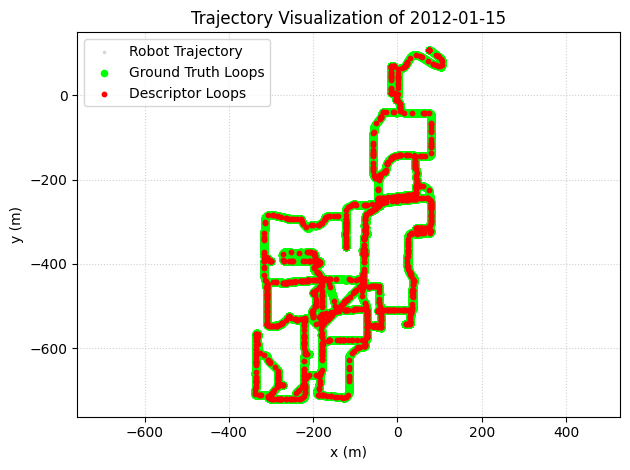

In [26]:
import pandas as pd
import numpy as np

r = 0.8
window = 200
min_travel = 80
tau = 0.2

for p in Path(DESCRIPTORS_FOLDER).iterdir():
    day = p.name.split("_")[1].removesuffix(".npy")
    print(f"Working with scans of {day}")

    # read csv files
    print("Reading files...")
    timestamps = pd.read_csv(f"{TIMESTAMP_FOLDER}/{day}.csv").to_numpy().flatten()
    gt = pd.read_csv(GT_POSE_FOLDER+"/groundtruth_"+day+".csv", 
                     header=None, 
                     names=["timestamp", "x", "y", "z", "roll", "pitch", "yaw"]
                     )
    gt = remove_nan(gt)

    # load descriptors
    descriptors = np.load(f"{DESCRIPTORS_FOLDER}/m2dp_{day}.npy")

    min_len = min(len(descriptors), len(timestamps))
    descriptors = descriptors[:min_len]
    timestamps = timestamps[:min_len]

    trajectory, valid_mask = get_gt_trajectory(gt, timestamps)
    descriptors = descriptors[valid_mask]

    print("Compute ground truth loops...")
    gt_indices, _ = gt_best_match_kdtree(trajectory, r, min_travel)

    print("Compute descriptor's loop closure detection...")
    candidates = loop_closure_candidates(descriptors, tau, window)
    pred_indices = pred_indices_from_candidates(candidates)

    print("Visualizing trajectory with loops...")
    visualize_trajectory(trajectory, gt_indices, pred_indices, day)
    break

In [24]:
print("GT ratio:", len(gt_indices) / len(trajectory))
print("Pred ratio:", len(pred_indices) / len(trajectory))


GT ratio: 0.9116337447329886
Pred ratio: 0.04064190299734034


In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)

precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
ap = average_precision_score(y_true, y_scores)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)
prec, rec, thresholds = precision_recall_curve(y_true, y_scores)
